In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


INSTALLING nlp FOR GETTING THE DATASET

In [2]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 7.6 MB/s 
     |████████████████████████████████| 243 kB 60.9 MB/s 


IMPORTING DATASETS

In [3]:
import nlp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
dataset=nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

PREPARING TRAIN,TEST AND VALIADTION SET

In [6]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

SOME PREPROCESSING LIKE TOKENIZATION,PADDING

In [7]:
def get_tweet_and_labels(data,data1=[]):
  tweets=[x['text'].lower() for x in data]
  labels=[x['label'] for x in data]
  for i in data1:
    tweets.append(i['text'])
    labels.append(i['label'])
  return tweets,labels

In [8]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [9]:
def text_cleaning(text):
  tokens = word_tokenize(text)
  # convert to lower case
  tokens = [w.lower() for w in tokens]
  # remove punctuation from each word
  
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  # print(type(words))
  w=[]
  lemmatizer=WordNetLemmatizer()
  for word in words:
    w.append(lemmatizer.lemmatize(word))
  return ' '.join(w)

ASSUMING THE AVERAGE LENGTH OF TWEETS TO BE 50

In [10]:
maxlen=50

In [11]:
train_tweets,train_labels=get_tweet_and_labels(train,test)

In [12]:
type(train_tweets)

list

In [13]:
train_tweets[0]

'i didnt feel humiliated'

In [14]:
def get_preprocessed_tweets(data):
  tweets=[]
  for i in data:
    tweets.append(text_cleaning(i))
  return tweets

In [15]:
train_tweets=get_preprocessed_tweets(train_tweets)

In [16]:
len(train_tweets)

18000

In [17]:
tokenizer=Tokenizer(oov_token='<UNK>')

In [18]:
classes=list(set(train_labels))

In [19]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((i,c) for i,c in enumerate(classes))

In [20]:
classes

['anger', 'fear', 'joy', 'sadness', 'surprise', 'love']

In [21]:
class_to_index

{'anger': 0, 'fear': 1, 'joy': 2, 'love': 5, 'sadness': 3, 'surprise': 4}

In [22]:
index_to_class

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness', 4: 'surprise', 5: 'love'}

In [23]:
name_to_ids=lambda labels:np.array([class_to_index[x] for x in labels])

In [24]:
train_labels=name_to_ids(train_labels)

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [26]:
import pickle

In [27]:
file='/content/gdrive/MyDrive/word_embeddings.pkl'
fileobj=open(file,'rb')
word_to_vec_map=pickle.load(fileobj)

In [28]:
text=''
for i in word_to_vec_map:
  text=text+' '+i.lower()

In [29]:
text=[text]

In [30]:
tokenizer.fit_on_texts(text)

In [31]:
len(tokenizer.word_index)

339252

In [32]:
def padding_seq(tokenizer,seq):
  seq=tokenizer.texts_to_sequences(seq)
  padded_seq=pad_sequences(seq,truncating='post',padding='post',maxlen=maxlen)
  return padded_seq

In [33]:
padded_train_seq=padding_seq(tokenizer,train_tweets)

In [34]:
padded_train_seq[0]

array([88495,  6191, 24843,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [35]:
val_tweets,val_labels=get_tweet_and_labels(val)

In [36]:
len(val_tweets)

2000

In [37]:
val_tweets=get_preprocessed_tweets(val_tweets)

In [38]:
val_tweets=padding_seq(tokenizer,val_tweets)

In [39]:
val_labels=name_to_ids(val_labels)

In [40]:
vocab_size=len(tokenizer.word_index)+1

In [41]:
vocab_size

339253

In [42]:
word_to_index=tokenizer.word_index
index_to_word={value:key for key,value in word_to_index.items()}

In [43]:
emb_dim=word_to_vec_map['the'].shape[0]

In [44]:
emb_matrix=np.zeros((vocab_size,emb_dim))
for i in tokenizer.word_index:
  j=word_to_index[i]
  try:
    emb_matrix[j,:]=word_to_vec_map[i]
  except:
    pass

In [45]:
emb_matrix.shape

(339253, 100)

In [46]:
from tensorflow.keras.initializers import Constant

ALL THE PREPROCESSING HAS BEEN DONE NOW LETS CREATE THE MODEL

In [47]:
model=tf.keras.models.Sequential([
                                tf.keras.layers.Embedding(len(tokenizer.word_index)+1,word_to_vec_map['the'].shape[0], #number of features
                                embeddings_initializer=Constant(emb_matrix), # initialize 
                                input_length=maxlen, 
                                trainable=False),
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                tf.keras.layers.Dense(len(classes),activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           33925300  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            19360     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 33,954,666
Trainable params: 29,366
Non-trainable params: 33,925,300
_________________________________________________________________


NOW LETS TRAIN OUR MODEL!!!

In [49]:
h=model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_tweets,val_labels),
    epochs=100,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
    ]
)

Epoch 1/100
563/563 [==============================] - 19s 15ms/step - loss: 1.1960 - accuracy: 0.5483 - val_loss: 0.8686 - val_accuracy: 0.6910
Epoch 2/100
563/563 [==============================] - 8s 13ms/step - loss: 0.6863 - accuracy: 0.7555 - val_loss: 0.5522 - val_accuracy: 0.8185
Epoch 3/100
563/563 [==============================] - 8s 14ms/step - loss: 0.4518 - accuracy: 0.8411 - val_loss: 0.4212 - val_accuracy: 0.8450
Epoch 4/100
563/563 [==============================] - 8s 14ms/step - loss: 0.3410 - accuracy: 0.8759 - val_loss: 0.3774 - val_accuracy: 0.8620
Epoch 5/100
563/563 [==============================] - 8s 13ms/step - loss: 0.2705 - accuracy: 0.8977 - val_loss: 0.3501 - val_accuracy: 0.8785
Epoch 6/100
563/563 [==============================] - 7s 13ms/step - loss: 0.2254 - accuracy: 0.9133 - val_loss: 0.3021 - val_accuracy: 0.8940
Epoch 7/100
563/563 [==============================] - 8s 14ms/step - loss: 0.1943 - accuracy: 0.9244 - val_loss: 0.2765 - val_accuracy

HELPER FUNCTION FOR PLOTTING

In [50]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

LETS PLOT HISTORY

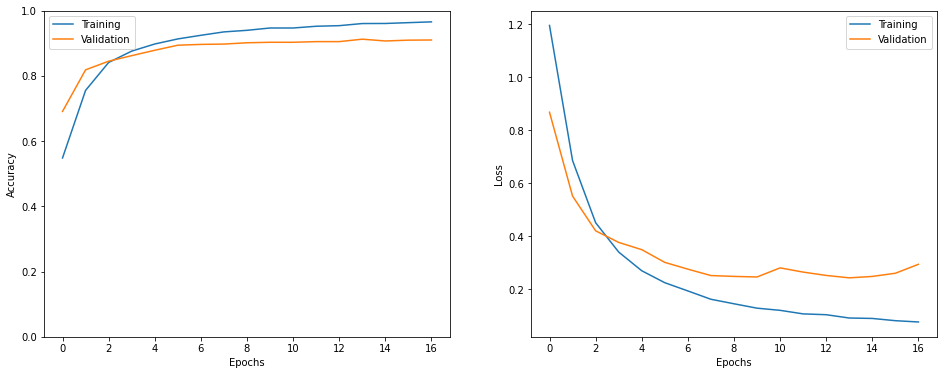

In [51]:
show_history(h)

In [52]:
s=['i am sad']
# s=s.split(' ')
test=get_preprocessed_tweets(s)
test=padding_seq(tokenizer,test)

In [53]:
y=np.argmax(model.predict(test), axis=-1)

In [54]:
index_to_class[y[0]]

'sadness'

LETS SAVE OUR MODEL AND OTHER NECESARY DATA ITEMS LIKE TOKENIZER,CLASS_TO_INDEX DICT AND ETC

In [55]:
model.save('model_sentiment_analysis_lstm.h5')

In [56]:
import pickle
file='index_to_class_sentiment_analysis_lstm.pkl'
fileobj=open(file,'wb')
pickle.dump(index_to_class,fileobj)

In [57]:
file='tokenizer_sentiment_analysis_lstm.pkl'
fileobj=open(file,'wb')
pickle.dump(tokenizer,fileobj)